# IS318 - Machine learning

## TP4 (durée 1h20)

L'objectif de ce TP est d'illustrer vos connaissances et compétences en *machine learning* en les mettant en pratique sur un jeu de données.
Il s'agira de prendre en main le jeu de données, d'appliquer des algorithmes d'apprentissage et d'essayer d'obtenir les meilleurs résultats possible sur un ensemble de test caché.

Comme pour les précédents TP, l'essentiel de l'évaluation portera sur la qualité de votre démarche méthodologique et la clarté de vos explications. Quelques points seront attribués en fonction des résultats obtenus sur l'ensemble de test, mais la rigueur de votre approche et la justification de vos choix resteront primordiales.

In [158]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn

X = np.load('X.npy')
y = np.load('y.npy')

## 1. Jeu de données (~10 min)

**(Question)** Explorez le jeu de données. Proposez une visualisation de quelques échantillons du jeu de données. Expliquez brièvement ce que les données représentent et comment elles sont organisées. Que remarquez-vous ?

(2000, 28, 28)
(2000,)


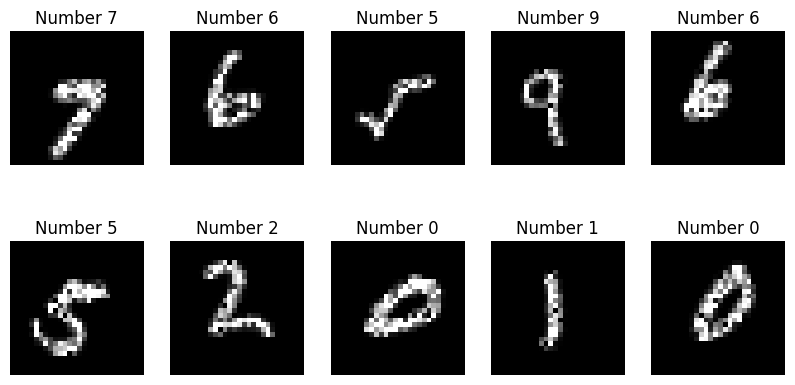

Number of unique numbers: 10
(2000, 784)


In [159]:
print(X.shape)
print(y.shape)

# print(X[0]) # To see values from 0 to 255

plt.figure(figsize=(10, 5))
random_indexes = np.random.choice(X.shape[0], size=10, replace=False)
for i, image_index in enumerate(random_indexes):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X[image_index], cmap=plt.cm.gray)
    plt.title(f"Number {y[image_index]}")
    plt.axis('off')
plt.show()
unique_y = len(np.unique(y))
print(f"Number of unique numbers: {unique_y}")

rng = np.random.default_rng(42)
permuted_indices = rng.permutation(len(X))

# Apply the permutation to both X and y
X = X[permuted_indices]
y = y[permuted_indices]


X_train_mean = X.mean(axis=0)
X_train_std = X.std(axis=0)

# print("std:", X_train_std)

X = X / 255
X_flat = X.reshape((-1,28*28))
print(X_flat.shape)
# X_test = (X_test - X_train_mean) / X_train_std  # Do the same for test data.

The presented dataset is a dataset of 2000 hand-drawn numbers in the form of an image 28x28 pixels. The range of values in the pixels values varies between 0 and 255. These values are generaly bad for machine learning algorithms that is why we need to normalize them.


This dataset was given with a groud truth label for each image containing 2000 instances where each instance is the true class of the given image.

## 2. Algorithme d'apprentissage (~20 min)

**(Question)** Choisissez un algorithme d'apprentissage approprié et appliquez-le pour obtenir un premier résultat de référence.
Expliquez brièvement comment cet algorithme fonctionne pour ce problème, et montrez ce qu'il a appris.
Rapportez, analysez et discutez les résultats.

In [160]:
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.svm import SVC

cross_validator = KFold(n_splits=10)

classifier = SVC() # All default parameters (kernel='rbf', C=1.0, ...)


def run_cross_validation(X, y, cross_validator, model):
  scores = []
  for train_index, val_index in cross_validator.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    model.fit(X_train, y_train)
    score = model.score(X_val, y_val)
    scores.append(score)

  return scores

scores = run_cross_validation(X_flat, y, cross_validator, classifier)
print(f"Cross-validation scores: {scores}")
print(f"RBF SVM 10 folds mean accuracy: {np.mean(scores) * 100:.2f}% +-{np.std(scores) * 100:.2f}%")

Cross-validation scores: [0.76, 0.77, 0.715, 0.79, 0.825, 0.665, 0.785, 0.79, 0.675, 0.745]
RBF SVM 10 folds mean accuracy: 75.20% +-4.96%


For this particular problem I chose to use a simple Suport Vector Machine (SVM) that separates the images represented as vectors of size 28x28 (num_features). The SVM tries to separate the classes in the high dimentional space of 28x28 using a hyperplan (for exmaple in 3D we would use a plane) while trying to stay as far as possible from all classes the points of the different classes.

Since the data is relatively small (2000) I decided to use a cross validation to simulate a high data and get a more precise accuracy score for my svm model. This choice proved to be the right one since the values for each cross validation split varies a lot averaging to a 69.25%.

**(Question)** Optimisez les hyperparamètres de votre modèle en utilisant un protocole approprié.
Rapportez, analysez et discutez les résultats.

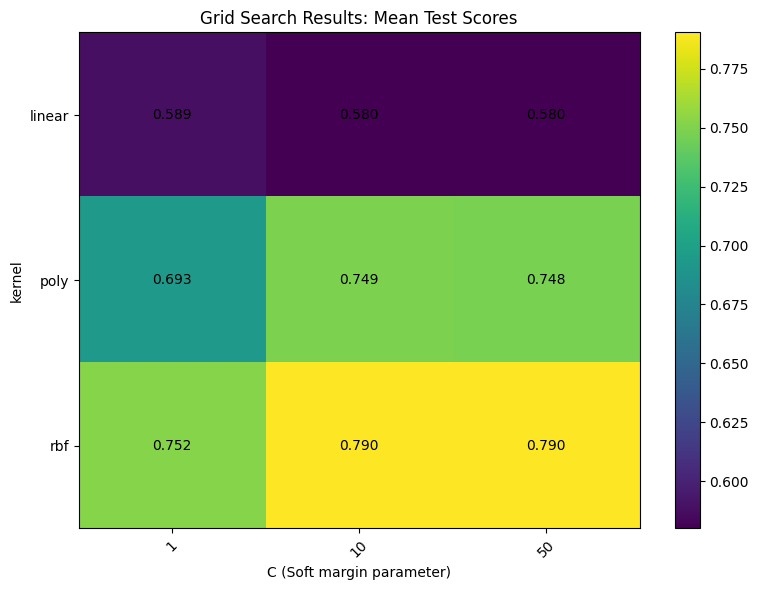

Best parameters: {'C': 10, 'kernel': 'rbf'}
Best score: 0.7905


In [161]:
grid_search_params = {
    'C' : [1, 10, 50],
    'kernel' : ['linear', 'poly', 'rbf']
}
param1_size = len(grid_search_params['C'])
param2_size = len(grid_search_params['kernel'])

classifier = SVC()
grid_search = GridSearchCV(classifier, grid_search_params, cv=cross_validator)
grid_search.fit(X_flat, y)

# Plotting the results of the grid search
scores = grid_search.cv_results_['mean_test_score'].reshape(param1_size, param2_size).T

fig, ax = plt.subplots(figsize=(8, 6))
cax = ax.imshow(scores, cmap='viridis', aspect='auto')
fig.colorbar(cax)
ax.set_xticks(np.arange(param1_size))
ax.set_yticks(np.arange(param2_size))
ax.set_xticklabels(grid_search_params['C'])
ax.set_yticklabels(grid_search_params['kernel'])
plt.xticks(rotation=45)
for i in range(param2_size):
    for j in range(param1_size):
        ax.text(j, i, f'{scores[i, j]:.3f}', ha='center', va='center', color='black')
ax.set_xlabel('C (Soft margin parameter)')
ax.set_ylabel('kernel')
ax.set_title('Grid Search Results: Mean Test Scores')
plt.tight_layout()
plt.show()

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")

To improve the performance of our SVM model we opted for a grid search which creates all the possible combinations of hyper parameters given to it and runs the cross validation on that particular model.

From the figure displayed we can conclude that the simple SVM model doesn't perform well on the given images since all the accuracy values are very low ($<0.718$).
In the category of SVMs the best hyperparameter combination would be Kernel -> rbf and soft margin -> 10.

## 3. Évaluation comparative (~20 min)

**(Question)** Appliquez un autre algorithme d'apprentissage approprié sur le même jeu de données.
Expliquez brièvement comment cet algorithme fonctionne pour ce problème, et montrez ce qu'il a appris.
Rapportez, analysez et discutez les résultats.
Comparez-les à ceux obtenus pour le modèle précédent.

In [162]:
import sklearn
import sklearn.cluster
import sklearn.datasets
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
import skimage.feature
import skimage.io
from sklearn.svm import SVC

import numpy as np
import matplotlib.pyplot as plt

from skimage import exposure

np.random.seed(42)

def hog_features(image, visualize=False):
    # Return a list of HOG features for a given image
    features = skimage.feature.hog(image, pixels_per_cell=(4, 4), cells_per_block=(1, 1),
                                   block_norm='L2-Hys', feature_vector=False, visualize=visualize)
    if visualize:
        return features[1]
    features = features.reshape(-1, features.shape[-1])
    return features

# ! The image was splited into 4x4 patches, and each patch has 9 features. Which means that in a 28x28 image.
# ! The 9 features are the histogram of gradients for each patch where each value is the oriented gradient value in a certain range.
# ! For example with 9 features (orientation bins) we would have 180/9 = 20 degrees per bin. 
# ! So the first bin would represent the gradients from 0 to 20 degrees, the second from 20 to 40, etc.


from sklearn.cluster import MiniBatchKMeans, KMeans

def build_vocabulary(features, voc_size=100):
    # Cluster features into a visual vocabulary with K-Means algorithm,
    # then return the trained classified object.
    # You can use the MiniBatchKMeans class for very similar results 
    # but faster run time
    kmeans = KMeans(n_clusters=voc_size, random_state=42)
    # kmeans = MiniBatchKMeans(n_clusters=voc_size, random_state=42)
    kmeans.fit(features)
    return kmeans

def build_codebook(features, vocabulary):
    # Given a vocabulary of visual words (KMeans classifier object),
    # compute the codebook (histogram) of the set of features for an image
    voc_size = len(vocabulary.cluster_centers_)
    codebook = np.zeros((len(features), voc_size))
    for i, f in enumerate(features):
        assignemnts = vocabulary.predict(f)
        for k in range(voc_size):
            codebook[i][k] = len(np.where(assignemnts == k)[0])
    codebook = codebook / codebook.sum(axis=1)[:, np.newaxis] # normalization
    return codebook

In [163]:

print(f"Original image shape : {X[0].shape}")
hog_f = hog_features(X[0])
print(f"HOG feature shape : {hog_f.shape}")

Original image shape : (28, 28)
HOG feature shape : (49, 9)


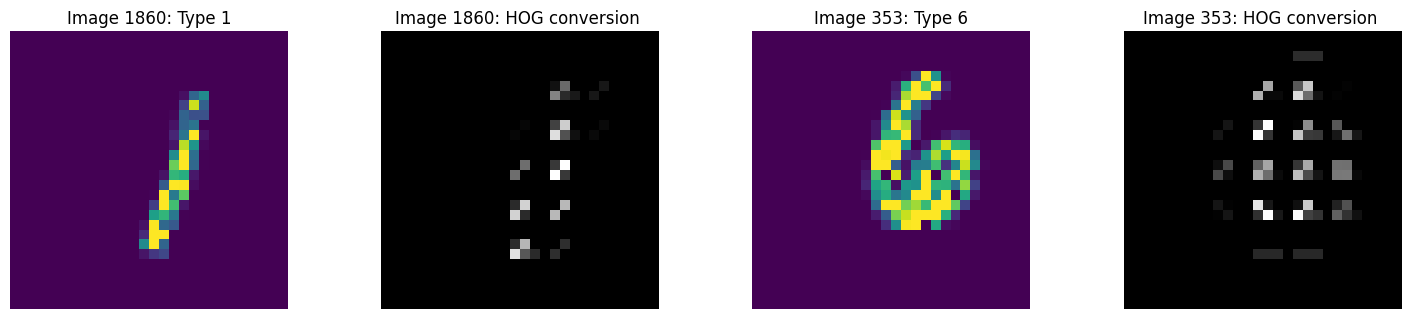

In [164]:
# ! Plotting the hog features of each images and visualizing it.

plt.figure(figsize=(15, 15))
random_indexes = np.random.choice(len(X), size=2, replace=False)
for i, image_index in enumerate(random_indexes):
    # Original image
    plt.subplot(5, 4, 2 * i + 1)
    plt.imshow(X[image_index])
    # print(images[image_index].shape) # (256, 256, 3)
    plt.title(f"Image {image_index}: Type {y[image_index]}")
    plt.axis('off')
    
    # HOG features
    plt.subplot(5, 4, 2 * i + 2)
    image_rescaled = hog_features(X[image_index], visualize=True)
    # print(image_rescaled.shape) # (256, 256) 
    hog_image_rescaled = exposure.rescale_intensity(image_rescaled, in_range=(0, 10))
    plt.imshow(hog_image_rescaled, cmap=plt.cm.gray)
    plt.title(f"Image {image_index}: HOG conversion ")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [165]:
# Computation of the HOG features for all the images
X_train_hog_features = []
for i in range(len(X)):
    X_train_hog_features.append(hog_features(X[i]))
    
X_train_hog_features_ = np.array(X_train_hog_features)
X_train_hog_features = X_train_hog_features_.reshape(-1,9)    
   

# Build the vocabulary from train features
vocabulary = build_vocabulary(X_train_hog_features, voc_size=100)


# Build the codebooks for train and test features into X_train variables 
X_train = build_codebook(X_train_hog_features_, vocabulary)
print(f"codebook shape: {X_train.shape}")

codebook shape: (2000, 100)


In [166]:
n_splits=10
cross_validator = KFold(n_splits=n_splits)

classifier = SVC() # All default parameters (kernel='rbf', C=1.0, ...)

scores = run_cross_validation(X_train, y, cross_validator, classifier)
print(f"Cross-validation scores: {scores}")
print(f"RBF SVM mean accuracy: {np.mean(scores) * 100:.2f}% +-{np.std(scores) * 100:.2f}%")

Cross-validation scores: [0.26, 0.35, 0.345, 0.385, 0.27, 0.34, 0.32, 0.305, 0.23, 0.275]
RBF SVM mean accuracy: 30.80% +-4.60%


The second algorithm i chose to use was the BOW (bag of words) approch that instead of representing images as an instance with 28x28 features we will now take each image and represent it as a set of gradient histograms also called Histogram of Oriented Gradients (HOG) which represents a caracterises a sub-image (patch).


Our BOW approch has given us a average accuracy score of 44.50% with the cross validation technique, which is worse than the best SVM model. We think that this bad performance is due to the large noise in the images which falsifies the results of the gradient in each patch and also the multitude of hyper parameters in our BOW method like the clustering algortihm, the patch size and the vocabulary size.

## 4. Amélioration des performances (~25 min)

**(Question)** Essayez d'obtenir les meilleurs résultats possibles sur ce jeu de données, en expliquant votre démarche. À défaut, suggérez des pistes d'amélioration.

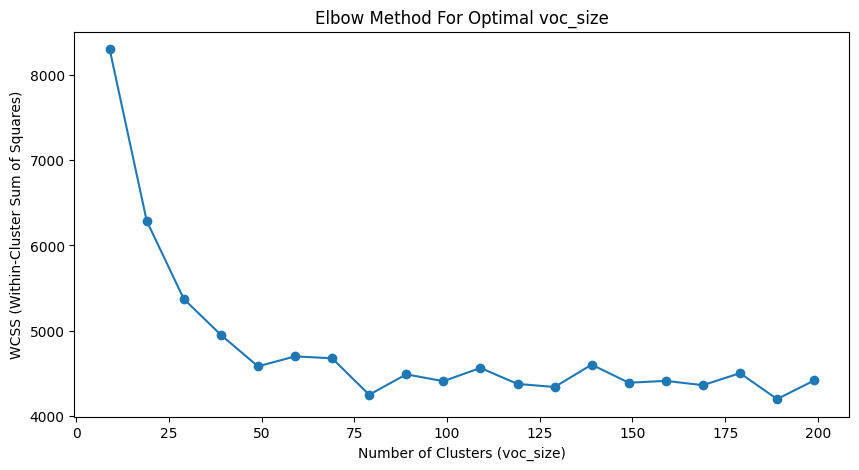

In [167]:
def build_vocabulary(features, voc_size=100):
    # Cluster features into a visual vocabulary with K-Means algorithm,
    # then return the trained classified object.
    # You can use the MiniBatchKMeans class for very similar results 
    # but faster run time
    # kmeans = KMeans(n_clusters=voc_size, random_state=42)
    kmeans = MiniBatchKMeans(n_clusters=voc_size, random_state=42)
    kmeans.fit(features)
    return kmeans

def wcss_kmeans(voc_size=100):
    # Build the vocabulary from train features
    vocabulary = build_vocabulary(X_train_hog_features, voc_size)
    return vocabulary.inertia_

wcss = [wcss_kmeans(voc_size) for voc_size in range(9, 200, 10)]


plt.figure(figsize=(10, 5))
plt.plot(range(9, 200, 10), wcss, marker='o')
plt.xlabel('Number of Clusters (voc_size)')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.title('Elbow Method For Optimal voc_size')
plt.show()

As explained previously there is a lot of hyper parameters that we need to tune in order to obtain the best BOW method. We decided to optimize the number of clusters in the kmeans clustering algorithm. And to do that we used the elbow method which represents the inetia of the kmeans model (wcss) compared to the number of clusters. The point where the curve breaks is the best number of clusters to use.

We tried the elbow method but no clear breaking point is visible, therefore we propose trying different combination of hyper parameters (example : clustering algorithm, patch size) or try an advanced method to finding the optimal vocabulary size like the method of the silhouette, which measures how close a point is to its nearest neighbor points, across all clusters.

## 5. Prédictions sur l'ensemble de test (~5 min)

**(Question)** Préparez et utilisez votre meilleur modèle pour obtenir les prédictions sur l'ensemble de test (fourni à la fin du TP).
Stockez les prédictions dans le même format que les labels `y` fournis au début du TP, et enregistrez-les dans un fichier nommé `y_test_preds.npy` à l'aide de la fonction `np.save`.

In [168]:
X_test = np.load('X_test.npy')

X_test = X_test / 255
X_X_flat = X_test.reshape((-1,28*28))# Normalize the test set


classifier = SVC(kernel='rbf', C=10)
classifier.fit(X_flat, y)
print(X_X_flat.shape)

y_test_preds = classifier.predict(X_X_flat)

np.save('y_test_preds.npy', y_test_preds)

(1000, 784)


Vérification du format de votre fichier de prédictions :

In [169]:
y_test_preds = np.load('y_test_preds.npy')
assert y_test_preds.dtype == y.dtype
assert y_test_preds.ndim == y.ndim
assert y_test_preds.shape[0] == X_test.shape[0]

Faites une archive de votre travail avec la commande : `tar cvzf ml-tp4.tgz ml-tp4.ipynb y_test_preds.npy`